In [24]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [25]:
import pathlib
data_dir = pathlib.Path('Detectar autos')

In [26]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

187


Tamaño de imagen

In [27]:
batch_size = 32
img_height = 180
img_width = 180

In [28]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 187 files belonging to 3 classes.
Using 150 files for training.


In [29]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 187 files belonging to 3 classes.
Using 37 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names)

['camioneta_familiar', 'deportivo', 'sedan']


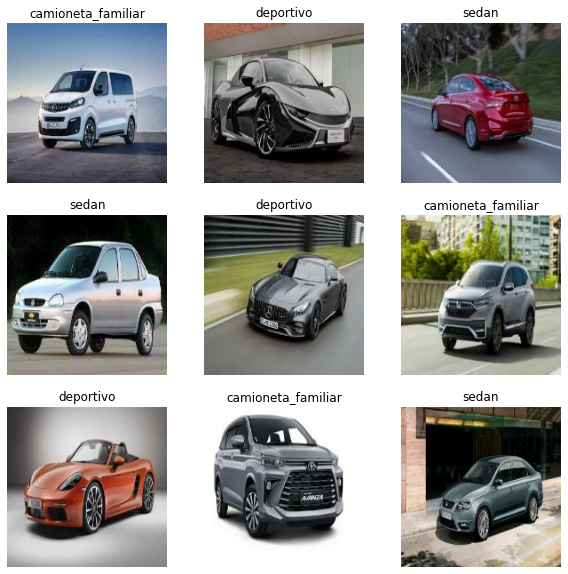

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [35]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)

Epoch 1/6
5/5 [==============================] - 2s 290ms/step - loss: 1.3369 - accuracy: 0.3200 - val_loss: 1.1556 - val_accuracy: 0.2703
Epoch 2/6
5/5 [==============================] - 1s 249ms/step - loss: 1.0808 - accuracy: 0.3933 - val_loss: 1.1413 - val_accuracy: 0.2432
Epoch 3/6
5/5 [==============================] - 1s 249ms/step - loss: 1.0359 - accuracy: 0.5067 - val_loss: 1.1481 - val_accuracy: 0.4324
Epoch 4/6
5/5 [==============================] - 1s 247ms/step - loss: 0.9694 - accuracy: 0.6067 - val_loss: 1.1303 - val_accuracy: 0.4595
Epoch 5/6
5/5 [==============================] - 1s 245ms/step - loss: 0.8944 - accuracy: 0.6200 - val_loss: 1.0994 - val_accuracy: 0.3784
Epoch 6/6
5/5 [==============================] - 1s 244ms/step - loss: 0.7574 - accuracy: 0.7467 - val_loss: 1.1404 - val_accuracy: 0.4324


In [36]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [37]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['camioneta_familiar' 'deportivo' 'sedan']


In [38]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [39]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [40]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [41]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [42]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [43]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


In [44]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

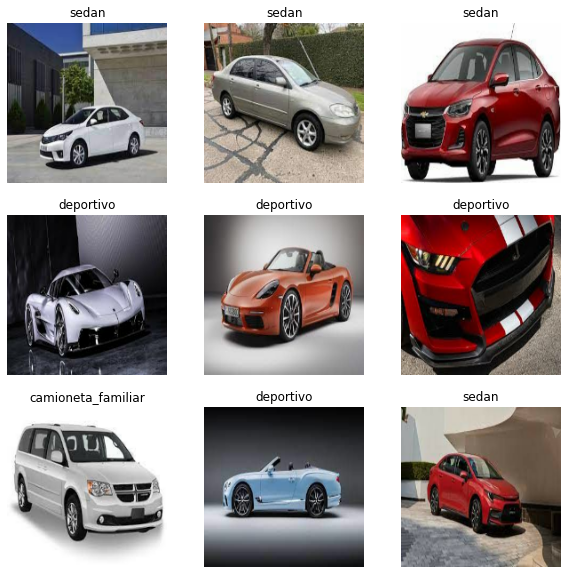

In [45]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [46]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)

Epoch 1/6
5/5 [==============================] - 2s 281ms/step - loss: 0.7034 - accuracy: 0.7133 - val_loss: 0.5842 - val_accuracy: 0.7838
Epoch 2/6
5/5 [==============================] - 1s 258ms/step - loss: 0.5912 - accuracy: 0.7333 - val_loss: 0.7627 - val_accuracy: 0.5676
Epoch 3/6
5/5 [==============================] - 1s 244ms/step - loss: 0.5378 - accuracy: 0.7667 - val_loss: 0.6833 - val_accuracy: 0.7027
Epoch 4/6
5/5 [==============================] - 1s 242ms/step - loss: 0.4154 - accuracy: 0.8867 - val_loss: 0.6239 - val_accuracy: 0.7838
Epoch 5/6
5/5 [==============================] - 1s 245ms/step - loss: 0.2566 - accuracy: 0.9533 - val_loss: 0.6102 - val_accuracy: 0.7568
Epoch 6/6
5/5 [==============================] - 1s 251ms/step - loss: 0.1790 - accuracy: 0.9667 - val_loss: 0.5446 - val_accuracy: 0.8108


In [48]:
foto = pathlib.Path(r'Prueba/camioneta.jpg')

img = tf.keras.utils.load_img(
    foto, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "El tipo de auto es: {} "
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
El tipo de auto es: camioneta_familiar 
